# Проект по теме: Статистический анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from math import factorial

## Загрузка данных

В данной работе будет проводиться анализ сервиса аренды самокатов GoFast. Для анализа и проверки гипотез будут использованы данные о некоторых пользователях из нескольких городов, а также об их поездках. 

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

||без подписки|с подпиской|
|-|-|-|
|абонентская плата|отсутствует|199 рублей в месяц|
|стоимость одной минуты поездки|8 рублей|6 рублей|
|стоимость старта|50 рублей|бесплатно|

In [2]:
try:
    users_data = pd.read_csv('users_go.csv')
    riders_data = pd.read_csv('rides_go.csv')
    subscriptions_data = pd.read_csv('subscriptions_go.csv')
except:
    users_data = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    riders_data = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    subscriptions_data = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

|Описание таблицы users_data|Описание таблицы riders_data|Описание таблицы subscriptions_data|
|-|-|-|
|**user_id** - уникальный идентификатор пользователя|**user_id** - уникальный идентификатор пользователя|**subscription_type** - тип подписки|
|**name** - имя пользователя|**distance**- расстояние, которое пользователь проехал в текущей сессии (в метрах)|**minute_price** - стоимость одной минуты поездки по данной подписке|
|**age** - возраст|**duration** - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»|**start_ride_price** - стоимость начала поездки|
|**city** - город|**date** - дата совершения поездки|**subscription_fee** - стоимость ежемесячного платежа|
|**subscription_type** - тип подписки (free, ultra)|

In [3]:
dict = {'users_data':users_data, 'riders_data':riders_data, 'subscriptions_data':subscriptions_data}
for name, dfr in dict.items():
    print('Информация по таблице', name)
    display(dfr.head(5))
    print(dfr.info())
    print()

Информация по таблице users_data


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None

Информация по таблице riders_data


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None

Информация по таблице subscriptions_data


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes
None



## Предобработка данных

Исходя из преварительного знакомства с данными, можно сделать вывод о том, что наименование колонок соответствует общепринятому стилю, пропущенные значения отсутствуют все столбцы имеют соответствующий тип данных (за исключением столбца date таблицы riders_data). 

Приведем столбец date таблицы riders_data к типу данных. И проверим наличие дубликатов.

In [4]:
riders_data['date'] = pd.to_datetime(riders_data['date'])

In [5]:
#lst = [users_data, riders_data, subscriptions_data]

for name, dfr in dict.items():
    print('Количество явных дулбликатов в таблице', name)
    display(dfr.duplicated().sum())

Количество явных дулбликатов в таблице users_data


31

Количество явных дулбликатов в таблице riders_data


0

Количество явных дулбликатов в таблице subscriptions_data


0

In [6]:
#избавимся от явных дубликатов
users_data = users_data[~users_data.duplicated()]

In [7]:
riders_data['month'] = riders_data['date'].dt.month #добавим колонку с месяцем

Поездки с аномально короткой длительностью и большим расстоянием примем за ошибку и удалим, благо таких значений не много от общего количества, всего 95 штук.

In [8]:
riders_data.loc[riders_data['duration'] < 1]

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


In [9]:
riders_data = riders_data.loc[riders_data['duration'] > 1]

## Исследовательский анализ данных

Для предварительного знакомства с данными и их распределением постараемся визуализировать распределение некоторых данных о пользователях и поездках:

* частота встречаемости городов;
*  соотношение пользователей с подпиской и без подписки;
*  возраст пользователей;
*  расстояние, которое пользователь преодолел за одну поездку;
*  продолжительность поездок.

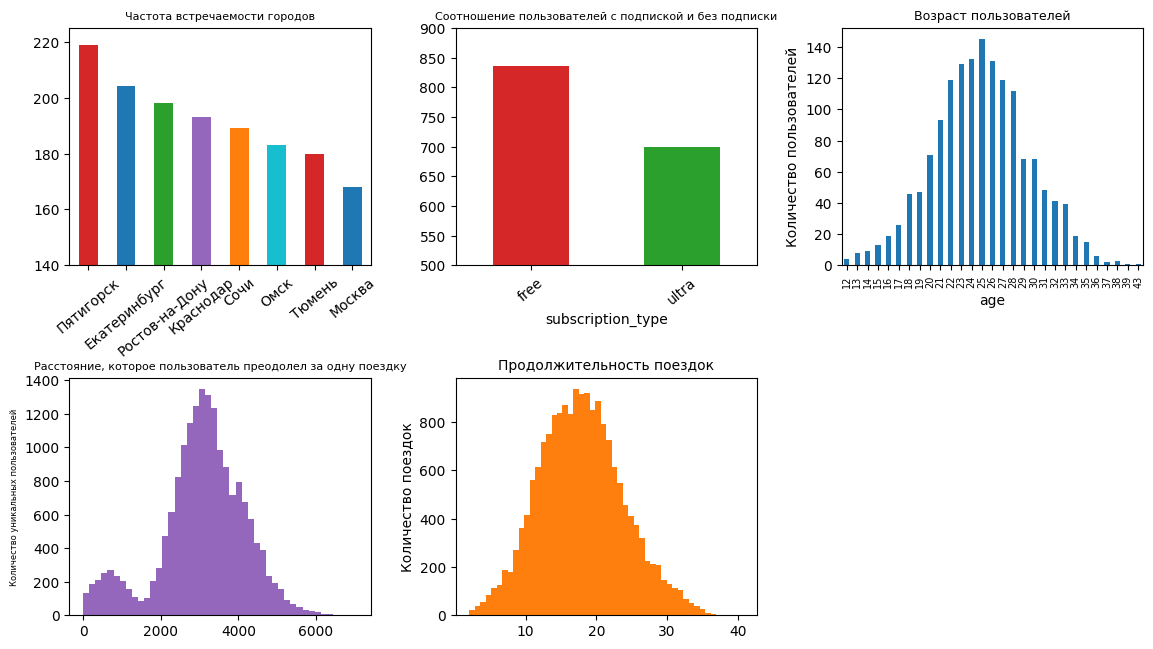

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(12,7))

fig.tight_layout(pad=3, h_pad=6)
users_data['city'].value_counts().plot(ylim=(140, 225), kind='bar', ax=axs[0, 0], 
                                       color = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:orange', 'tab:cyan'])
axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=40)
axs[0, 0].set_title('Частота встречаемости городов', fontsize=8)
axs[0, 0].set_xlabel('')

users_data['subscription_type'].value_counts().plot(ylim=(500, 900), kind='bar', ax=axs[0, 1], color=['tab:red', 'tab:green'])
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=40)
axs[0, 1].set_title('Соотношение пользователей с подпиской и без подписки', fontsize=8)

users_data['age'].value_counts().sort_index().plot.bar(ax=axs[0, 2], ylabel='Количество пользователей')
axs[0, 2].set_title('Возраст пользователей', fontsize=9)
axs[0, 2].set_xticklabels(axs[0, 2].get_xticklabels(), fontsize=7)

riders_data['distance'].plot(kind='hist', bins=45, ax=axs[1, 0], color=['tab:purple'])
axs[1, 0].set_ylabel('Количество уникальных пользователей', fontsize=6)
axs[1, 0].set_title('Расстояние, которое пользователь преодолел за одну поездку',fontsize=8)

riders_data['duration'].plot(kind='hist', bins=50, ax=axs[1, 1], color=['tab:orange'])
axs[1, 1].set_ylabel('Количество поездок', fontsize=10)
axs[1, 1].set_title('Продолжительность поездок',fontsize=10)

axs[1, 2].set_visible(False)
plt.show()

Посмотрев на визуализированные данные можно сделать несколько выводов:

Наибольшее количество данных по городам Пятигорск и Екатеринбург, меньше всего (на удивление пользователей из Москвы). Выборка по городам распределена относительно равномерно в диапазоне 180 - 210 значений.

In [11]:
users_data['city'].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

Из описания числовых значений можно заметить, что данные предсавлены за 2021 год. Среднее время поездки 18 минут и 3129 метров

In [12]:
riders_data.describe()

,user_id,distance,duration,date,month
count,17973.000000,17973.000000,17973.000000,17973,17973.000000
mean,841.551995,3059.863833,17.896480,2021-06-30 19:41:36.745117696,6.486786
min,1.000000,0.855683,2.035632,2021-01-01 00:00:00,1.000000
25%,484.000000,2538.839628,13.670439,2021-04-02 00:00:00,4.000000
50%,887.000000,3129.029255,17.714122,2021-06-30 00:00:00,6.000000
75%,1213.000000,3762.636244,21.747016,2021-09-28 00:00:00,9.000000
max,1534.000000,7066.003772,40.823963,2021-12-30 00:00:00,12.000000
std,435.144929,1108.814612,5.975424,NaN,3.436024


График распределения расстояний, которые кользователь преодалел за одну поездку напоминает бимодальное распределение с характерным пиками пиком среднего расстояния и небольшим пиком на расстоянии около 700 м

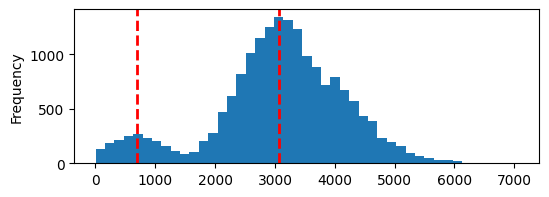

In [13]:
riders_data['distance'].plot(kind='hist', bins=45, figsize=(6, 2))
plt.axvline(700, color='red', linestyle='dashed', linewidth=2)
plt.axvline(riders_data['distance'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.show()

Пользователи с подпиской и без подписки соотносятся примерно 45.6% на 54,4% соответственно. Круговая диаграмма представлена ниже. 

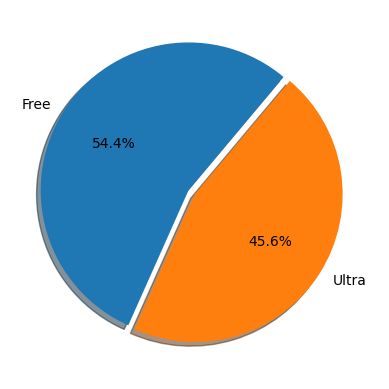

In [14]:
plt.pie(users_data['subscription_type'].value_counts(), 
        explode = (0.05, 0), 
        labels = ['Free', 'Ultra'], 
        shadow=True, 
        startangle=50,
        autopct='%1.1f%%'
       )
plt.show()

Наиболее часто встречаются пользователи от 20 до 30 лет

## Объединение данных

### Объединим данные о пользователях, поездках и подписках в один датафрейм

In [15]:
df = riders_data.merge(users_data.merge(subscriptions_data, on='subscription_type'), on='user_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int32         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


In [16]:
print('Отношение количества строк таблицы riders_data равно', df.shape[0] / riders_data.shape[0])
print('Данные не потерялись, размерность датафрема не изменилась' if (df.shape[0] / riders_data.shape[0]) == 1 else 'Упс...Кое-что пропало...')
print('Суммарное количество пропусков в таблице равно', df.isna().sum().sum())

Отношение количества строк таблицы riders_data равно 1.0
Данные не потерялись, размерность датафрема не изменилась
Суммарное количество пропусков в таблице равно 0


### Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:

* c данными о пользователях без подписки;
* с данными о пользователях с подпиской.

In [17]:
df_ultra = df[df['subscription_type'] == 'ultra']
df_free = df[df['subscription_type'] == 'free']

### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

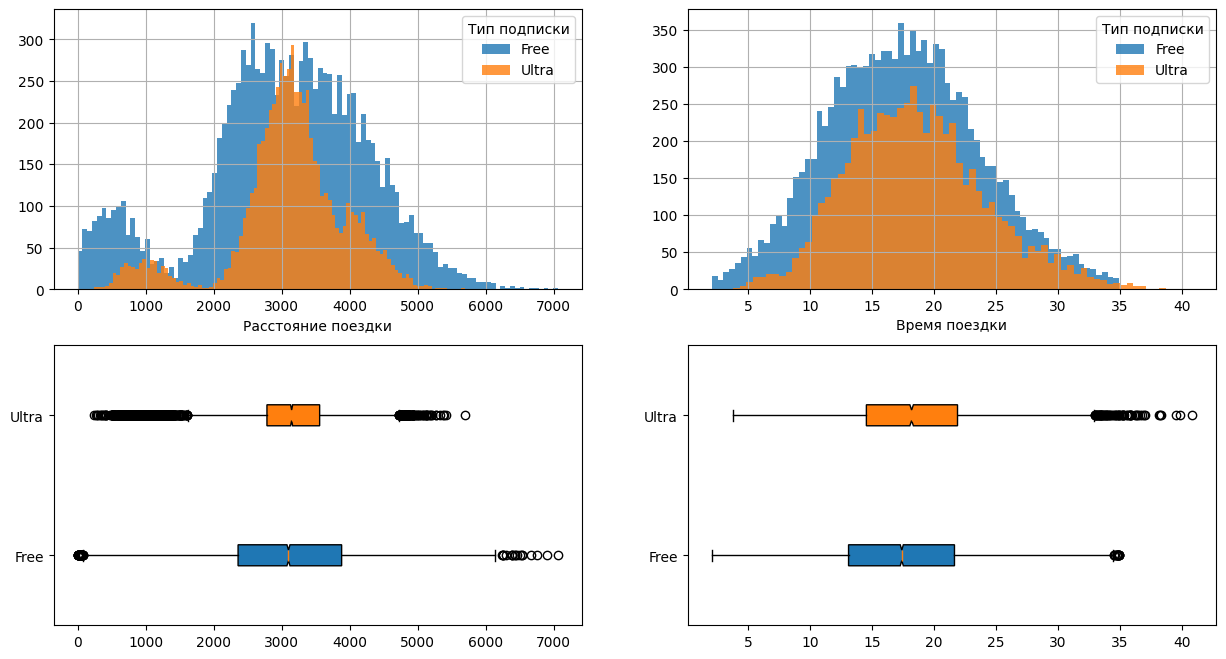

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

df_free['distance'].hist(bins=100, ax=axs[0, 0], alpha=0.8)
df_ultra['distance'].hist(bins=100, ax=axs[0, 0], alpha=0.8)
axs[0, 0].legend(['Free', 'Ultra'], title='Тип подписки')
axs[0, 0].set_xlabel('Расстояние поездки')


df_free['duration'].hist(bins=70, ax=axs[0, 1], alpha=0.8)
df_ultra['duration'].hist(bins=70, ax=axs[0, 1], alpha=0.8)
axs[0, 1].legend(['Free', 'Ultra'], title='Тип подписки')
axs[0, 1].set_xlabel('Время поездки')


box1 = axs[1, 0].boxplot([df_free['distance'], df_ultra['distance']], vert=False, patch_artist=True,
                      labels=['Free', 'Ultra'], notch=True)
colors = ['tab:blue', 'tab:orange']
for patch, color in zip(box1['boxes'], colors):
    patch.set_facecolor(color)


box2 = axs[1, 1].boxplot([df_free['duration'], df_ultra['duration']], vert=False, patch_artist=True,
                      labels=['Free', 'Ultra'], notch=True)
colors = ['tab:blue', 'tab:orange']
for patch, color in zip(box2['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

Распределение данных по пользователям из двух групп очень похоже как по расстоянию, так и времени поездки, имеют схожие средние значения.
Похожее распределение гистограмм может свидетельствовать о схожем поведении пользователей с подпиской и без. Средние величины представлены ниже.

In [62]:
mean_params = df.pivot_table(index='subscription_type', values=['duration', 'distance'])
mean_params

,distance,duration
subscription_type,,
free,3028.374239,17.530771
ultra,3115.445388,18.541985


Судя по диаграммам размаха данные пользователей с Ultra подпиской имеют больше выбросов, поскольку данные расположены более "кучно". Возможно, это может быть свзано с тем, что подписку оформляют люди, которые привыкли добираться до конкретных мест на самокате (до работы, остановки, учебы, метро)

In [20]:
print('Среднее количество поездок в год у одного пользователя с подпиской Ultra', df_free.groupby('user_id')['date'].count().mean())
print('Среднее количество поездок в год у одного пользователя с подпиской Free', df_ultra.groupby('user_id')['date'].count().mean())

Среднее количество поездок в год у одного пользователя с подпиской Ultra 13.740119760479041
Среднее количество поездок в год у одного пользователя с подпиской Free 9.298998569384835


На удивление пользователи без подписки в среднем имеют больше поездок за год.

## Подсчёт выручки

In [65]:
# группировка данных в таблицу
user_by_month = df.groupby(['user_id', 'month']) \
                  [['distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_type','subscription_fee']] \
                  .agg({'distance':['sum', 'count'], 
                        'duration':'sum', 
                        'minute_price':'first', 
                        'start_ride_price':'first',
                        'subscription_type':'first',
                        'subscription_fee':'first'}).reset_index()

# переименование столбцов
user_by_month.columns = ['user_id', 'month', 'sum_distance', 'count_of_trips', 'sum_duration', 'minute_price', 'start_ride_price', 'subscription_type', 'subscription_fee']

# округление длительности в большую сторону
user_by_month['sum_duration'] = np.ceil(user_by_month['sum_duration'])

# добавление итогового столбца с помесячной суммой выручки
user_by_month['monthly_revenue'] = user_by_month['count_of_trips'] * user_by_month['start_ride_price'] + \
                                   user_by_month['start_ride_price'] + \
                                   user_by_month['minute_price'] * user_by_month['sum_duration']

user_by_month

,user_id,month,sum_distance,count_of_trips,sum_duration,minute_price,start_ride_price,subscription_type,subscription_fee,monthly_revenue
0,1,1,7027.511294,2,42.0,6,0,ultra,199,252.0
1,1,4,754.159807,1,7.0,6,0,ultra,199,42.0
2,1,8,6723.470560,2,45.0,6,0,ultra,199,270.0
3,1,10,5809.911100,2,32.0,6,0,ultra,199,192.0
4,1,11,7003.499363,3,54.0,6,0,ultra,199,324.0
...,...,...,...,...,...,...,...,...,...,...
11295,1534,6,3409.468534,2,25.0,8,50,free,0,350.0
11296,1534,8,7622.453034,2,48.0,8,50,free,0,534.0
11297,1534,9,4928.173852,1,23.0,8,50,free,0,284.0
11298,1534,11,13350.015305,4,77.0,8,50,free,0,866.0


In [22]:
print('Суммарное количество пропусков в таблице равно', user_by_month.isna().sum().sum())

Суммарное количество пропусков в таблице равно 0


## Проверка гипотез

### Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 

Сформируем гипотезы для проведения двухвыборочного t-теста для независимых выборок.
* Н0 - пользователи с подпиской тратят времени на поездки столько же, сколько и пользователи с подпиской.
* Н1 - пользователи с подпиской тратят больше времени на поездки.

In [23]:
sample_ultra_duration = df_ultra['duration']
sample_free_duration = df_free['duration']
print(f"Среднее время поездки выборки пользователей с подспиской {df_ultra['duration'].mean()}")
print(f"Среднее время поездки выборки пользователей без подсписки {df_free['duration'].mean()}")

Среднее время поездки выборки пользователей с подспиской 18.54198516280583
Среднее время поездки выборки пользователей без подсписки 17.530771268800226


In [24]:
#выберем уровень статистической значимости
alpha = 0.05

results = st.ttest_ind(sample_ultra_duration, sample_free_duration, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.7044680744539e-28
Отвергаем нулевую гипотезу


**Есть основания утверждать что пользователи с подпиской тратят больше времени на поездки.**

### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Проверим можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

Сформируем гипотезы для проведения одностороннего t-теста для независимой выборки.
* Н0 - среднее расстояние, которое проезжают пользоватли с подпиской равно 3130 метров.
* Н1 - среднее расстояние, которое проезжают пользоватли с подпиской больше 3130 метров.

In [25]:
sample_ultra_distance = df_ultra['distance']
print(f"Среднее расстояние поездки выборки пользователей с подспиской {df_ultra['distance'].mean()}")

Среднее расстояние поездки выборки пользователей с подспиской 3115.4453880370247


In [26]:
#выберем уровень статистической значимости
alpha = 0.05

optimal_value = 3130
results = st.ttest_1samp(sample_ultra_distance, optimal_value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


**По результатам статистического теста не достаточно оснований отвергнуть нулевую гипотезу. Скорее всего, пользователи с подпиской действительно** *в среднем* **проезжают расстояние близкое к оптимальному с точни зрения износа самоката.**

### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Сформируем гипотезы для проведения двухвыборочного t-теста для независимых выборок.
* Н0 - помесячная выручка пользователей с подпиской равна выручке пользователей без подписки. 
* Н1 - помесячная выручка пользователей с подпиской меньше выручки пользователей без подписки. 

Добавим к ранее сгруппированной таблице столбец с типом подписки

In [55]:
sample_ultra_monthly_revenue = user_by_month.loc[user_by_month['subscription_type'] == 'ultra', 'monthly_revenue']
sample_free_monthly_revenue = user_by_month.loc[user_by_month['subscription_type'] == 'free', 'monthly_revenue']

In [56]:
#выберем уровень статистической значимости
alpha = 0.05

results = st.ttest_ind(sample_ultra_monthly_revenue, sample_free_monthly_revenue, alternative='less', equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.0
Отвергаем нулевую гипотезу


**По результатам теста у нас достаточное оснований полагать что пользователи с подпиской приносят в среднем меньше выручки по месяцам.**

### Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

В данном случае условие напоминает две зависимые (парные) выборки, следовательно, нам нужно проверить гипотезу о равенстве среднего количества генеральной совокупности (обращений в тех.поддержку) до и после изменения. 

Для этого нам подойдет метод `scipy.stats.ttest_rel`.

## Распределения

### Отделу маркетинга GoFast поставили задачу: 
нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была например 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Количество процентов  100 успехов при 1169 испытаний:  0.052522319024517476

Количество успехов при 0.05% неудач 100.0



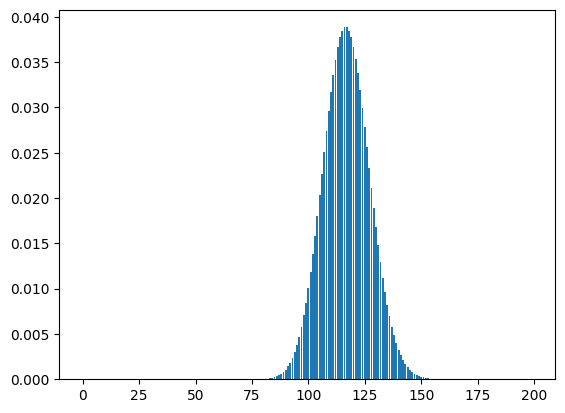

In [31]:
n = 1169
k = 100
p = 0.1
mu = n * p
sigma = (n * p * (1 - p))**0.5

distr = st.binom(n, p)
print(f'Количество процентов  {k} успехов при {n} испытаний: ', distr.cdf(k))
print()
print(f'Количество успехов при 0.05% неудач', distr.ppf(0.05))
print()


distr = []
end_range = 200

for k in range(0, end_range):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1-p)**(n-k) 
    distr.append(prob)
    
plt.bar(range(0, end_range), distr)
plt.show()

**Ответ:** для того, чтобы минимум **100** клиентов продлили подписку необходимо **1169** клиентам раздать промокоды

### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей

Ввиду очень большого значения повторений и невозможности считать факториалы таких числе, попробудем аппроксимировать распределением Пуассона

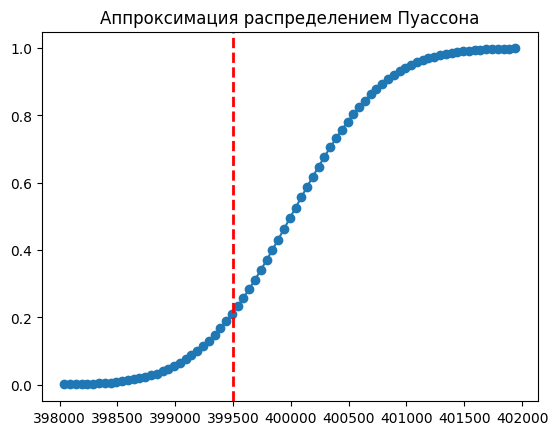

In [32]:
n = 1000000
p = 0.4
mu = n * p
sigma = (n * p * (1-p))**0.5
lmbd = n * p
x = 399500

max_value = int(mu + 4 * sigma)
min_value = int(mu - 4 * sigma)

poisson_probs = []
for k in range(min_value, max_value + 1, 50):
    poisson_prob = st.poisson.cdf(k, lmbd)
    poisson_probs.append(poisson_prob)

plt.plot(range(min_value, max_value + 1, 50), poisson_probs, '-o')
plt.title('Аппроксимация распределением Пуассона')
plt.axvline(x, color='red', linestyle='dashed', linewidth=2)
plt.show()

In [33]:
print(f'Вероятность того, что уведомление откроют не более {x} раз равна {round(st.poisson.cdf(x, lmbd) * 100, 1)}%')

Вероятность того, что уведомление откроют не более 399500 раз равна 21.5%


# Вывод

В результате исследования были проанализированы данные о сервисе аренды самокатов GoFast из таких городов как Тюмень, Омск, Москва, Ростов-на-Дону, Краснодар, Пятигорск, Екатеринбург, Сочи.

Перед анализом была выполнена предобработка данных, в результате которой удаолено незначительное количество дубликатов в таблице users_data. 
Также обнаруже в таблице riders_data 95 аномальных значений - поездки длительностью в пол минуты, за которые было пройдено в среднем 5км. Такие значения были удалены. 

Наиболее часто услугами сервиса пользуются люди от 20 до 30 лет.

По результатам работы с данными можно сделать несколько выводов для бизнеса, которые могут помочь скорректировать стратегию развития:
1. Пользователей без подписки незначительно больше, чем пользователей с подпиской, соотносятся они примерно 45.6% на 54,4% соответственно.
2. Пользователи с подпиской чаще пользуются сервисом. Среднее количество поездок в год у одного пользователя с подпиской Ultra и Free 13.7 и 9.3 соответственно.
3. Средние значения времени и дальности представлены ниже:

In [64]:
mean_params

,distance,duration
subscription_type,,
free,3028.374239,17.530771
ultra,3115.445388,18.541985


4. Пользователи с подпиской тратят больше времени на поездки, как следствие  среднем проезжают расстояние больше оптимального с точки зрения износа самоката (3130 метров).
5. Помесячная выручка от пользователей с подпиской меньшне, чем от пользователей без подписки.